# Forecasting Inflation with AutoML in Amazon SageMaker Autopilot

## 1. Set up the environment

Import the dependencies.

In [1]:
import io
import json
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Get the SageMaker session.

In [2]:
session = sagemaker.Session()

Get the SageMaker execution role.

In [3]:
role = sagemaker.get_execution_role()

Get the default S3 bucket.

In [4]:
bucket = session.default_bucket()

## 2. Define the auxiliary functions for working with the FRED-MD data

In [5]:
def transform_series(
    x,
    tcode
):
    """
    Transform the time series.

    Parameters:
    ========================================================================================================
    x: pandas.Series
        Time series.
    
    tcode: int.
        Transformation code.
    """
    
    if tcode == 1:
        # No transformation
        return x
    
    elif tcode == 2:
        # First order absolute difference
        return x.diff()
    
    elif tcode == 3:
        # Second order absolute difference
        return x.diff().diff()
    
    elif tcode == 4:
        # Logarithm
        return np.log(x)
    
    elif tcode == 5:
        # First order logarithmic difference
        return np.log(x).diff()
    
    elif tcode == 6:
        # Second order logarithmic difference
        return np.log(x).diff().diff()
    
    elif tcode == 7:
        # Percentage change
        return x.pct_change()
    
    else:
        raise ValueError(f"unknown `tcode` {tcode}")

In [6]:
def get_common_series(
    start_vintage,
    end_vintage
):
    """
    Get the list of complete time series included in all dataset releases between two vintages.
    
    Parameters:
    ========================================================================================================
    start_vintage: str.
        The first vintage, in "YYYY-MM" format.

    end_vintage: str.
        The last vintage, in "YYYY-MM" format.
    """
    # Generate the date range
    dates = pd.date_range(
        start=f"{start_vintage.split('-')[0]}-{start_vintage.split('-')[1]}-01",
        end=f"{end_vintage.split('-')[0]}-{end_vintage.split('-')[1]}-01",
        freq="MS"
    )
    
    # Create a list for storing the names of the complete time series
    series = []
    
    # Loop across the dates
    for date in dates:
        # Load the data for the considered date
        data = pd.read_csv(f"data/{date.year}-{format(date.month, '02d')}.csv", skiprows=list(range(1, 11)), index_col=0)
        
        # Drop the incomplete time series
        data = data.loc[:, data.isna().sum() == 0]
        
        # Save the names of the complete time series
        series.append([c.upper() for c in data.columns])
    
    # Get the list of complete time series included in the dataset on all dates
    series = list(set.intersection(*map(set, series)))
    
    return series

In [7]:
def get_data(
    vintage,
    series_names,
    target_name,
    target_tcode,
    n_lags,
):
    """
    Get the data for a selected vintage.

    Parameters:
    ========================================================================================================
    vintage: str.
        The vintage of the dataset, in "YYYY-MM" format.
    
    series_names: str.
        The time series to be included in the dataset.
    
    target_name: string.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    n_lags: int.
        The number of autoregressive lags.
    """
    # Get the file path
    file = f"data/{vintage}.csv"
    
    # Get the time series
    data = pd.read_csv(file, skiprows=list(range(1, 11)), index_col=0)
    data.index = pd.to_datetime(data.index)
    data.columns = [c.upper() for c in data.columns]
    data = data.loc[:, series_names]
    
    # Get the transformation codes
    tcodes = pd.read_csv(file, nrows=1, index_col=0)
    tcodes.columns = [c.upper() for c in tcodes.columns]
    
    # Override the target's transformation code
    tcodes[target_name] = target_tcode
    
    # Transform the time series
    data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))
    
    # Add the lags
    data = data[[target_name]].join(data.shift(periods=list(range(1, 1 + n_lags)), suffix="_LAG"))
    
    # Drop the missing values resulting from applying the transformations and taking the lags
    data = data.dropna()
    
    return data

In [8]:
def get_real_time_data(
    start_vintage,
    end_vintage,
    series_names,
    target_name,
    target_tcode,
    n_lags,
):

    """
    Get the real-time data between two vintages.
    
    Parameters:
    ========================================================================================================
    start_vintage: str.
        The first vintage, in "YYYY-MM" format.

    end_vintage: str.
        The last vintage, in "YYYY-MM" format.

    series_names: str.
        The time series to be included in the dataset.
    
    target_name: string.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    n_lags: int.
        The number of autoregressive lags.
    """
    
    # Generate the date range
    dates = pd.date_range(
        start=f"{start_vintage.split('-')[0]}-{start_vintage.split('-')[1]}-01",
        end=f"{end_vintage.split('-')[0]}-{end_vintage.split('-')[1]}-01",
        freq="MS"
    )
    
    # Get the last month of data for each date in the considered range
    data = pd.concat([
        get_data(
            vintage=f"{date.year}-{format(date.month, '02d')}",
            series_names=series_names,
            target_name=target_name,
            target_tcode=target_tcode,
            n_lags=n_lags,
        ).iloc[-1:]
        for date in dates
    ])

    return data

## 3. Prepare the FRED-MD data and upload it to S3

Select the target name.

In [9]:
target_name = "CPIAUCSL"

Select the target transformation code.

In [10]:
target_tcode = 7

Select the number of autoregressive lags.

In [11]:
n_lags = 1

Get the names of the complete time series over the relevant time window.

In [12]:
series_names = get_common_series(
    start_vintage="2023-01",
    end_vintage="2025-01",
)

In [13]:
print(f"Number of complete time series: {len(series_names)}")

Number of complete time series: 101


**Note:** Make sure that the target has a complete time series.

In [14]:
print(f"Target time series is complete: {target_name in series_names}")

Target time series is complete: True


### 3.1 Training data (January 1960 - December 2022)

Get the training data.

In [15]:
training_data = get_data(
    vintage="2023-01",
    series_names=series_names,
    target_name=target_name,
    target_tcode=target_tcode,
    n_lags=n_lags,
)

In [16]:
training_data.shape

(756, 102)

In [17]:
training_data.head()

,CPIAUCSL,CPIAPPSL_LAG_1,S&P 500_LAG_1,BOGMBASE_LAG_1,IPCONGD_LAG_1,CPIMEDSL_LAG_1,CLF16OV_LAG_1,DSERRG3M086SBEA_LAG_1,RPI_LAG_1,BAA_LAG_1,...,M2REAL_LAG_1,TB6MS_LAG_1,CES0600000007_LAG_1,FEDFUNDS_LAG_1,PAYEMS_LAG_1,NDMANEMP_LAG_1,HOUSTW_LAG_1,GS1_LAG_1,IPB51222S_LAG_1,CE16OV_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,-0.001360,0.000000,0.031476,0.007782,0.032241,-0.004598,0.006704,-0.000435,0.010195,0.02,...,0.000296,0.31,40.0,-0.01,0.010018,0.000940,5.880533,0.33,0.003771,0.012489
1960-02-01,0.001362,0.000000,-0.017594,-0.027375,0.031237,0.004577,-0.000464,-0.001288,0.003194,0.06,...,0.002663,-0.11,40.1,0.00,0.001844,0.002191,5.774552,-0.11,-0.008822,0.000092
1960-03-01,0.000000,0.004405,-0.039545,-0.006279,-0.011454,-0.000021,-0.000189,0.000855,0.001143,0.00,...,-0.000690,-0.44,39.7,-0.02,0.004394,0.001406,5.897154,-0.37,-0.001262,0.004169
1960-04-01,0.004420,-0.004405,-0.013719,0.019917,0.001151,-0.000021,-0.008009,-0.001113,0.001909,-0.09,...,0.003051,-0.69,39.5,-0.13,-0.001083,-0.000156,5.796058,-0.64,0.037315,-0.014537
1960-05-01,0.001016,0.002195,0.012822,0.006050,0.006879,-0.000020,0.017105,0.001450,0.003419,-0.05,...,-0.001770,-0.06,39.8,0.08,0.006571,0.000936,5.758902,0.02,0.001220,0.019690


In [18]:
training_data.tail()

,CPIAUCSL,CPIAPPSL_LAG_1,S&P 500_LAG_1,BOGMBASE_LAG_1,IPCONGD_LAG_1,CPIMEDSL_LAG_1,CLF16OV_LAG_1,DSERRG3M086SBEA_LAG_1,RPI_LAG_1,BAA_LAG_1,...,M2REAL_LAG_1,TB6MS_LAG_1,CES0600000007_LAG_1,FEDFUNDS_LAG_1,PAYEMS_LAG_1,NDMANEMP_LAG_1,HOUSTW_LAG_1,GS1_LAG_1,IPB51222S_LAG_1,CE16OV_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2022-08-01,0.001182,-0.008731,0.003272,0.020878,0.002354,-0.002263,-0.000073,-0.005725,0.005287,-0.06,...,0.001516,0.65,40.7,0.47,0.003529,0.001440,5.828946,0.37,0.005473,0.001359
2022-09-01,0.003860,0.003002,0.061189,0.002552,0.002001,0.002340,0.004405,0.004969,0.000902,-0.06,...,-0.001366,0.29,40.6,0.65,0.001914,0.000000,5.866468,0.26,-0.023190,0.002663
2022-10-01,0.004384,-0.005018,-0.076961,-0.039297,-0.003327,0.001204,-0.000577,-0.000110,0.000343,0.54,...,-0.009819,0.58,40.7,0.23,0.001760,0.001643,5.905362,0.61,-0.044559,0.000983
2022-11-01,0.000963,-0.003989,-0.032860,0.017939,0.007207,-0.012970,0.000164,-0.001612,0.004201,0.57,...,-0.008468,0.55,40.8,0.52,0.001717,0.001026,5.755742,0.54,-0.011513,-0.001619
2022-12-01,-0.000794,0.009221,0.050102,0.027932,-0.005122,-0.000208,-0.000723,-0.000714,0.001583,-0.19,...,-0.003793,0.30,40.4,0.70,0.001669,0.000000,5.880533,0.30,0.052320,-0.000416


Upload the training data to S3.

In [19]:
training_data_s3_uri = session.upload_string_as_file_body(
    body=training_data.to_csv(index=False),
    bucket=bucket,
    key="data/train.csv"
)

### 3.2 Validation data (January 2023 - December 2023)

Get the validation data.

In [20]:
validation_data = get_real_time_data(
    start_vintage="2023-02",
    end_vintage="2024-01",
    series_names=series_names,
    target_name=target_name,
    target_tcode=target_tcode,
    n_lags=n_lags,
)

In [21]:
validation_data.shape

(12, 102)

In [22]:
validation_data.head()

,CPIAUCSL,CPIAPPSL_LAG_1,S&P 500_LAG_1,BOGMBASE_LAG_1,IPCONGD_LAG_1,CPIMEDSL_LAG_1,CLF16OV_LAG_1,DSERRG3M086SBEA_LAG_1,RPI_LAG_1,BAA_LAG_1,...,M2REAL_LAG_1,TB6MS_LAG_1,CES0600000007_LAG_1,FEDFUNDS_LAG_1,PAYEMS_LAG_1,NDMANEMP_LAG_1,HOUSTW_LAG_1,GS1_LAG_1,IPB51222S_LAG_1,CE16OV_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2023-01-01,0.005171,0.001093,-0.001305,-0.017163,-0.001970,0.006370,0.002665,0.001815,0.001156,-0.48,...,-0.009026,0.07,40.3,0.32,0.001684,-0.002659,5.673323,-0.05,0.089649,0.004513
2023-02-01,0.003700,0.006166,0.012265,-0.011890,-0.003827,-0.006406,0.005236,0.000155,-0.000198,-0.09,...,-0.011819,0.12,40.7,0.23,0.003256,0.002866,5.693732,0.01,-0.156876,0.005598
2023-03-01,0.000530,-0.000190,0.029608,0.012958,0.004357,-0.001751,0.002523,-0.002390,0.000244,0.09,...,-0.010153,0.14,40.6,0.24,0.002101,0.000205,5.883322,0.24,-0.010831,0.001105
2023-04-01,0.003678,-0.005423,-0.027615,0.047303,0.008267,0.002449,0.002883,-0.001214,0.001741,0.12,...,-0.011819,-0.04,40.4,0.08,0.001062,-0.000614,5.455321,-0.25,0.132155,0.003593
2023-05-01,0.001241,0.000062,0.037807,-0.042044,0.009639,0.002751,-0.000258,0.001078,-0.001069,-0.18,...,-0.011697,0.02,40.5,0.18,0.001889,-0.000205,5.680173,0.00,-0.023617,0.000864


In [23]:
validation_data.tail()

,CPIAUCSL,CPIAPPSL_LAG_1,S&P 500_LAG_1,BOGMBASE_LAG_1,IPCONGD_LAG_1,CPIMEDSL_LAG_1,CLF16OV_LAG_1,DSERRG3M086SBEA_LAG_1,RPI_LAG_1,BAA_LAG_1,...,M2REAL_LAG_1,TB6MS_LAG_1,CES0600000007_LAG_1,FEDFUNDS_LAG_1,PAYEMS_LAG_1,NDMANEMP_LAG_1,HOUSTW_LAG_1,GS1_LAG_1,IPB51222S_LAG_1,CE16OV_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.006312,-0.003455,0.036760,-0.023194,0.011769,-0.002421,0.000910,0.001606,0.000249,-0.01,...,-0.000946,0.08,40.5,0.04,0.001005,-0.003091,5.978886,0.13,0.069384,0.001663
2023-09-01,0.003957,0.002346,-0.011315,0.023761,-0.001062,0.003799,0.004395,-0.002743,0.000386,0.28,...,-0.008129,0.01,40.6,0.21,0.001451,-0.000413,5.648974,0.00,0.020955,0.001376
2023-10-01,0.000449,-0.009664,-0.010886,-0.005983,-0.001065,0.000523,0.000536,0.003154,0.000484,0.14,...,-0.007336,0.03,40.6,0.00,0.001896,0.000825,5.693732,0.07,-0.001694,0.000532
2023-11-01,0.000969,0.008600,-0.032197,0.004615,-0.009127,0.001311,-0.001198,-0.002894,0.002211,0.47,...,-0.001883,0.02,40.6,0.00,0.000957,-0.000206,5.828946,-0.02,-0.011889,-0.002156
2023-12-01,0.003030,-0.013959,0.043689,0.016890,0.000794,0.002378,0.002406,0.000695,0.004510,-0.34,...,0.001038,-0.09,40.6,0.00,0.001102,-0.001653,5.888878,-0.14,0.008339,0.003627


Upload the training data to S3.

In [24]:
validation_data_s3_uri = session.upload_string_as_file_body(
    body=validation_data.to_csv(index=False),
    bucket=bucket,
    key="data/valid.csv"
)

### 3.3 Test data (January 2024 - December 2024)

Get the test data.

In [25]:
test_data = get_real_time_data(
    start_vintage="2024-02",
    end_vintage="2025-01",
    series_names=series_names,
    target_name=target_name,
    target_tcode=target_tcode,
    n_lags=n_lags,
)

In [26]:
test_data.shape

(12, 102)

In [27]:
test_data.head()

,CPIAUCSL,CPIAPPSL_LAG_1,S&P 500_LAG_1,BOGMBASE_LAG_1,IPCONGD_LAG_1,CPIMEDSL_LAG_1,CLF16OV_LAG_1,DSERRG3M086SBEA_LAG_1,RPI_LAG_1,BAA_LAG_1,...,M2REAL_LAG_1,TB6MS_LAG_1,CES0600000007_LAG_1,FEDFUNDS_LAG_1,PAYEMS_LAG_1,NDMANEMP_LAG_1,HOUSTW_LAG_1,GS1_LAG_1,IPB51222S_LAG_1,CE16OV_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.003054,0.006340,0.049214,-0.006385,0.001302,-0.001066,-0.004029,0.000338,0.002019,-0.65,...,0.002345,-0.12,40.3,0.0,0.002119,-0.001038,5.976351,-0.32,-0.029835,-0.004228
2024-02-01,0.004421,-0.006946,0.025174,-0.013800,0.003154,0.000709,-0.001046,0.003393,0.006056,0.04,...,-0.002856,-0.10,39.9,0.0,0.001455,0.001869,5.831882,-0.17,0.128097,-0.000192
2024-03-01,0.003781,0.012501,0.042276,0.006269,-0.008632,-0.004786,0.000896,-0.004448,-0.000623,0.09,...,-0.004681,0.07,40.4,0.0,0.001712,-0.001453,5.783825,0.13,-0.147877,-0.001142
2024-04-01,0.003129,0.000995,0.031156,-0.011423,0.005064,0.005095,0.002797,0.001669,0.001947,-0.02,...,0.000689,0.02,40.6,0.0,0.001994,-0.001247,5.755742,0.07,-0.016114,0.003089
2024-05-01,0.000057,0.005434,-0.011296,-0.016134,-0.001547,-0.000393,0.000518,-0.001450,0.000015,0.25,...,-0.001769,0.04,40.3,0.0,0.001043,0.000831,5.662960,0.15,0.056998,0.000155


In [28]:
test_data.tail()

,CPIAUCSL,CPIAPPSL_LAG_1,S&P 500_LAG_1,BOGMBASE_LAG_1,IPCONGD_LAG_1,CPIMEDSL_LAG_1,CLF16OV_LAG_1,DSERRG3M086SBEA_LAG_1,RPI_LAG_1,BAA_LAG_1,...,M2REAL_LAG_1,TB6MS_LAG_1,CES0600000007_LAG_1,FEDFUNDS_LAG_1,PAYEMS_LAG_1,NDMANEMP_LAG_1,HOUSTW_LAG_1,GS1_LAG_1,IPB51222S_LAG_1,CE16OV_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2024-08-01,0.001872,-0.005552,0.022435,-0.014871,-0.011551,-0.004212,0.002497,-0.000139,0.001099,0.02,...,0.000060,-0.14,40.5,0.00,0.000561,0.000207,5.605802,-0.21,-0.049788,0.000416
2024-09-01,0.001799,0.007097,-0.010855,0.016598,0.005519,0.001316,0.000712,-0.000147,0.001146,-0.24,...,0.002961,-0.27,40.6,0.00,0.001001,0.000622,5.655992,-0.47,-0.026124,0.001041
2024-10-01,0.002441,0.008723,0.025777,-0.017428,-0.000065,0.005288,0.000890,0.000803,0.001201,-0.18,...,0.002048,-0.32,40.7,-0.20,0.001404,-0.000622,5.631212,-0.40,0.001554,0.002660
2024-11-01,0.003129,-0.026028,0.029977,0.010731,-0.001219,-0.001297,-0.001305,0.000572,0.004366,0.21,...,0.001763,-0.12,40.5,-0.30,0.000226,-0.000831,5.793014,0.17,0.026854,-0.002276
2024-12-01,0.003931,0.016518,0.023478,0.012617,0.004693,0.000011,-0.000736,-0.002184,0.001635,0.15,...,0.003236,0.01,40.6,-0.19,0.001332,-0.000831,5.659482,0.13,-0.001906,-0.001692


Upload the test data to S3.

**Note:** Make sure to drop the target time series from the test dataset before uploading to S3.

In [29]:
test_data_s3_uri = session.upload_string_as_file_body(
    body=test_data.drop(labels=[target_name], axis=1).to_csv(index=False, header=False),
    bucket=bucket,
    key="data/test.csv"
)

## 4. Configure and run the AutoML job

Define the AutoML job configuration.

In [30]:
automl = sagemaker.automl.automlv2.AutoMLV2(
    problem_config=sagemaker.automl.automlv2.AutoMLTabularConfig(
        target_attribute_name=target_name,
        algorithms_config=["randomforest", "extra-trees", "xgboost", "linear-learner", "nn-torch"],
        mode="ENSEMBLING",
        problem_type="Regression",
    ),
    job_objective={"MetricName": "MSE"},
    base_job_name="us-cpi",
    output_path=f"s3://{bucket}/output/",
    role=role,
    sagemaker_session=session,
)

Run the AutoML job.

In [31]:
automl.fit(
    inputs=[
        sagemaker.automl.automlv2.AutoMLDataChannel(
            s3_data_type="S3Prefix",
            s3_uri=training_data_s3_uri,
            channel_type="training",
            compression_type=None,
            content_type="text/csv;header=present"
        ),
        sagemaker.automl.automlv2.AutoMLDataChannel(
            s3_data_type="S3Prefix",
            s3_uri=validation_data_s3_uri,
            channel_type="validation",
            compression_type=None,
            content_type="text/csv;header=present"
        ),
    ]
)

{"AutoMLJobName": "us-cpi-2025-09-02-19-09-51-543", "AutoMLJobInputDataConfig": [{"DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": "s3://sagemaker-eu-west-1-661670223746/data/train.csv"}}, "ChannelType": "training", "ContentType": "text/csv;header=present"}, {"DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": "s3://sagemaker-eu-west-1-661670223746/data/valid.csv"}}, "ChannelType": "validation", "ContentType": "text/csv;header=present"}], "OutputDataConfig": {"S3OutputPath": "s3://sagemaker-eu-west-1-661670223746/output/"}, "AutoMLProblemTypeConfig": {"TabularJobConfig": {"TargetAttributeName": "CPIAUCSL", "ProblemType": "Regression", "Mode": "ENSEMBLING", "CandidateGenerationConfig": {"AlgorithmsConfig": [{"AutoMLAlgorithms": ["randomforest", "extra-trees", "xgboost", "linear-learner", "nn-torch"]}]}}}, "RoleArn": "arn:aws:iam::661670223746:role/service-role/AmazonSageMaker-ExecutionRole-20191030T162743", "AutoMLJobObjective": {"MetricName": "MSE"}, "S

## 5. Generate the AutoML predictions

Create the model.

In [32]:
model = automl.create_model(
    name=f"us-cpi-{np.random.randint(0,10000)}",
    sagemaker_session=session,
)

Create the transformer.

In [33]:
transformer = model.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

Run the batch transform job.

In [34]:
transformer.transform(
    data=test_data_s3_uri,
    content_type="text/csv",
)

INFO:sagemaker:Creating transform job with name: us-cpi-8874-2025-09-02-19-18-14-744


2025-09-02T19:22:24,785 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.8/dist-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 3460 M
Python executable: /usr/bin/python3
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: null
Metrics dir: null
Netty threads: 0
Netty client threads: 0
Default workers per model: 4
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Preload model: false
Prefer direct buffer: false
2025-09-02T19:22:24,847 [WARN ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerLifeCycle - attachIOStreams() threadName=W-9000-model
2025-09-02T19:22:24,932 [INFO ] W-9000-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - model_service_worker started with args: --sock-type unix --sock-name /home/model-server/

## 6. Evaluate the AutoML predictions

Get the AutoML predictions from S3.

In [35]:
predictions = session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test.csv.out"
)

Cast the predictions to data frame.

In [36]:
predictions = pd.read_csv(io.StringIO(predictions), header=None)
predictions.index = test_data.index
predictions.columns = ["Forecast"]

Add the actual values to the data frame.

In [37]:
predictions.insert(0, "Actual", test_data[target_name])

In [38]:
predictions

,Actual,Forecast
sasdate,,
2024-01-01,0.003054,0.003925
2024-02-01,0.004421,0.004762
2024-03-01,0.003781,0.003877
2024-04-01,0.003129,0.003374
2024-05-01,0.000057,0.003521
2024-06-01,-0.000562,0.001291
2024-07-01,0.001549,0.002623
2024-08-01,0.001872,0.002978
2024-09-01,0.001799,0.002686


Calculate the correlations between the predictions and the actual values.

In [39]:
correlations = predictions.corr()

In [40]:
correlations

,Actual,Forecast
Actual,1.00000,0.68762
Forecast,0.68762,1.00000


Visualize the predictions against the actual values.

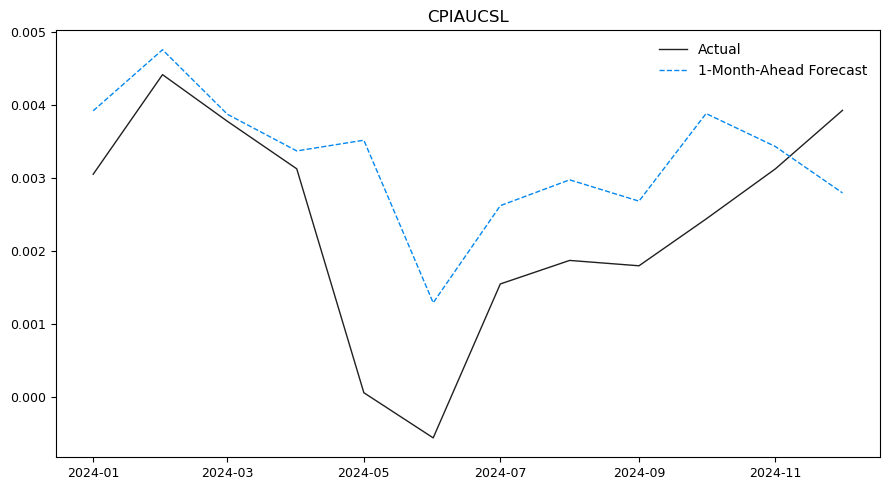

In [41]:
plt.subplots(figsize=(9, 5))
plt.plot(predictions["Actual"], color="#202020", lw=1, label="Actual")
plt.plot(predictions["Forecast"], "--", color="#0588f0", lw=1, label="1-Month-Ahead Forecast")
plt.tick_params(axis="both", which="major", labelsize=9)
plt.tick_params(axis="both", which="minor", labelsize=9)
plt.legend(bbox_to_anchor=(1, 0, 0, 1), frameon=False, prop={"size": 10})
plt.title(target_name, size=12)
plt.tight_layout()
plt.show()

Calculate the error metrics.

In [42]:
errors = pd.DataFrame({
    "RMSE": [format(root_mean_squared_error(y_true=predictions["Actual"], y_pred=predictions["Forecast"]), ".4%")],
    "MAE": [format(mean_absolute_error(y_true=predictions["Actual"], y_pred=predictions["Forecast"]), ".4%")]
})

In [43]:
errors

,RMSE,MAE
0,0.1385%,0.1069%
